## <span style="color:blue">code group summary --- still testing mostly fucntional</span>

### <span style="color:red">Beach litter survey results 2020/2021 Switzerland</span>

#### <span style="color:#008891">Definition of significant values</span>

#### <span style="color:#008891">National survey result </span>

#### <span style="color:#008891">Lac Léman results</span>

#### <span style="color:#008891">Lac Léman code group utilisation and availability </span>


questions or comments: analyst@hammerdirt.ch

In [1]:
# sys, file and nav packages:
import os
import datetime as dt
import csv

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt 
from statsmodels.distributions.empirical_distribution import ECDF


# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
import seaborn as sns
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML

# mapping
import geopandas as gpd


# home brew utitilties
import utilities.utility_functions as ut

# documenting
from IPython.display import Markdown as md


# variables/arrays that are frequently used:
# project lakes
the_lakes = [
    "Bielersee",
    "Walensee",
    "Lac Léman",
    "Zurichsee",
    "Neuenburgersee",
    "Thunersee",
    "Lago Maggiore",
    "Brienzersee",
]

# standard formats already in use for charts, these will gradually
# define the chart style or output format for the app
# you can just apply these as kwargs to different elements...


# table kwargs
table_k = dict(loc="top left", bbox=(0,0,1,1), colWidths=[.5, .5], cellLoc='center')
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center')
tabtickp_k = dict(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False)

# chart kwargs
title_k = {'loc':'left', 'pad':10, 'linespacing':1.5, 'fontsize':12}
title_k20 = {'loc':'left', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'dodgerblue'}
title_k17 = {'loc':'left', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'salmon'}
titler_k20 = {'loc':'right', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'dodgerblue'}
titler_k17 = {'loc':'right', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'salmon'}
xlab_k = {'labelpad':10, 'fontsize':12}
ylab_k = {'labelpad':14, 'fontsize':14}
titler_k = {'loc':'right', 'pad':10, 'linespacing':1.5, 'fontsize':12}

# use these to format date axis in charts
weeks = mdates.WeekdayLocator(byweekday=1, interval=4)
days = mdates.DayLocator(bymonthday=1, interval=1)
months = mdates.MonthLocator(bymonth=[3,6,9,12])
wks_fmt = mdates.DateFormatter('%d')
mths_fmt = mdates.DateFormatter('%b')

# map marker size:
markerSize = 100

In [2]:
# the local file structure. The resources are located in the corresponding directory.
survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

# set some parameters:
start_date = '2020-04-01'
end_date = dt.datetime.today().strftime('%Y-%m-%d')

# define a code group, there are predefined code groups in
# the resources folder under mlwcodedefs
const = ut.json_file_get(F"{output}/code_groups/construction.json")
group_one = ['G27','G35', 'G30', 'G25','G31','G32','G33','G34', 'G21', 'G24']
group_one_name = "kiosk waste"
code = "gone"
group_names = [group_one_name]

# define a second group or leave as all
# this note book will only compare the two groups 
group_two = const
group_two_name = 'construction waste'
code = "gtwo"

# keep track of the figures you produce
table_num = 1
figure_num = 1
map_num = 1


# choose a lake:
lake = 'Lac Léman'

# define a significant event:
sig = .9
one_minus_sig = (1-sig)

# define explanatory variables:
expv = ['population','streets','buildings','rivs']

# name the folder:
name_of_project = 'testproject'

# use this to store things:
project_directory = ut.make_project_folder(output, name_of_project)

# probably want to keep these... the works already done
# aggregated survey data
dfAgg = pd.read_csv(F"{survey_data}/results_with_zeroes_aggregated_parent.csv")
dfAgg['date'] = pd.to_datetime(dfAgg['date'])

# non aggregated survey data
dfSurveys = pd.read_csv(F"{survey_data}/results_with_zeroes.csv")
dfSurveys['date'] = pd.to_datetime(dfSurveys['date'])

# beach data
dfBeaches = pd.read_csv(F"{location_data}/beaches_with_ranks.csv")
dfBeaches.set_index('slug', inplace=True)
dfBeaches.rename(columns={"NUMPOINTS":"intersects"}, inplace=True)

# code definitions
dfCodes = pd.read_csv(F"{code_defs}/mlw_codes.csv")

# geo data: explantory variables, index by slug and make a map:
dfStreets = pd.read_csv(F"{geo_data}/exp_variables/strasse_1000.csv", index_col='slug')['length']
dfBlds = pd.read_csv(F"{geo_data}/exp_variables/builds_500.csv", index_col='slug')['area']
dfRivs = dfBeaches['intersects']

# restrict to lakes only
dfS = dfAgg.loc[(dfAgg.water_name.isin(the_lakes))&(dfAgg.date >= start_date)].copy()

# map geo values to survey results:
dfS['population']=dfS.location.map(lambda x: dfBeaches.loc[x]['population'])
dfS['streets'] = dfS.location.map(lambda x: dfStreets.loc[x])
dfS['buildings'] = dfS.location.map(lambda x: dfBlds.loc[x])
dfS['rivs'] = dfS.location.map(lambda x: dfRivs.loc[x].values[0])

# get a list of the codes in the current data
codes_in_use = dfS.code.unique()

# seperate out group_one:
dfGone = dfS.loc[dfS.code.isin(group_one)].copy()

# group all the codes in group 2 or all the codes not in group one
if 'all' in group_two:
    dfGtwo = dfS.loc[~dfS.code.isin(group_one)].copy()
    group_two_name = 'the rest'
else:
    dfGtwo = dfS.loc[dfS.code.isin(group_two)].copy()

group_names.append(group_two_name)

# gather up the created dataframes
groupdfs = [dfGone,dfGtwo]

# get the codes that have been accounted for in groupone and grouptwo:
codes_accounted_for = set(list(dfGone.code.unique())) | set(list(dfGtwo.code.unique()))

# get the codes that have not been accounted for
group_three = [x for x in codes_in_use if x not in codes_accounted_for]

# make a boolean to alert to the presence of data in group three
# if you choose all as the second group then groupthree will be empty
gthree = len(group_three) > 0

# keep track of the files you are exporting:
files_generated = []

# save files
survey_csv = F"{project_directory}/survey_data.csv"
files_generated.append(survey_csv)
dfS.to_csv(survey_csv, index=False)

beaches_csv = F"{project_directory}/beach_data.csv"
files_generated.append(beaches_csv)
dfBeaches.to_csv(beaches_csv, index=False)

# daily totals for each group
# and assign the name 'rest' to either group_two or group_three
# that depends on the value of group_two
if gthree:
    group_three_name = 'the rest'
    dfGthree = dfS.loc[dfS.code.isin(group_three)].copy()
    project_groups = [group_one, group_two, group_three]
    group_names.append(group_three_name)
    groupdfs.append(dfGthree)
else:
    project_groups = [group_one, group_two]

# put the dfs in a dictionary and key to group name
groupdfs = {x:groupdfs[i] for i,x in enumerate(group_names)}

# daily totals for each group
# name the columns to keep when aggregating:
cols_to_keep = ['loc_date','location','water_name', 'date','population','streets','buildings','rivs']

# get the daily total for each group and store in a data frame:
for name in group_names:
    new_name = F"{name}_dt"
    dtdf = groupdfs[name].groupby(cols_to_keep, as_index=False).agg({"pcs_m":"sum", "quantity":"sum"})    
    dtdf.set_index('loc_date', inplace=True)
    groupdfs.update({new_name:dtdf})

# get each survey total per location and date (all codes included)
# we can check combined values with this
allDf = dfS.groupby(['loc_date','location','water_name', 'date','population','streets','buildings','rivs'], as_index=False).agg({"pcs_m":"sum", "quantity":"sum"})
allDf.set_index('loc_date', inplace=True)

# add that to the collection of dataframes
groupdfs.update({"dfDtAll":allDf})
groupkeys = groupdfs.keys()

# get the percent of survey total for each group
dt_names = [F"{name}_dt" for name in group_names]
    
for name in dt_names:
    groupdfs[name]["p_total"] = groupdfs[name].index.map(lambda x: groupdfs[name].loc[x].pcs_m/groupdfs["dfDtAll"].loc[x].pcs_m)
    groupdfs[name]['p_total'] = groupdfs[name]['p_total']*100
    groupdfs[name]['p_total'] = groupdfs[name]['p_total'].round(2)

# summarize the results by lake.
# Number of locations and surveys with or without code for each lake
# Make column headers plain english, make table

# place to store the summaries
regional_summaries = []

# creating a summary for each df in groupdfs
for name in dt_names:
    this_data = groupdfs[name]
    this_agg = {'loc_date':'count', 'location':'nunique', 'pcs_m':'median', 'p_total':'mean'}
    this_data.reset_index(inplace=True)
    regional_summary = this_data.groupby('water_name').agg(this_agg)
    regions = list(regional_summary.index)
    
    # the mean of all the group data 
    rs_mean = this_data.groupby('water_name').pcs_m.mean()
    
    # the number of samples with group pcs_m > 0
    regional_summary["# samps with"] = regional_summary.index.map(lambda x: F"{this_data[(this_data.water_name == x)&(this_data.pcs_m > 0)].pcs_m.count()}/{this_data[this_data.water_name == x].loc_date.nunique()}")
    
    hasGpi = this_data[this_data.quantity > 0]
    # count the number of locations with the code value per lake
    lakes_with = hasGpi[['water_name', 'location']].groupby(['water_name']).nunique('location')
    
    regional_summary['locations with'] = regional_summary.index.map(lambda x: F"{lakes_with.loc[x].location}/{regional_summary.loc[x].location}")
    
    # rename the columns to ui style
    new_columns = {'loc_date':'# samples',
                   "locations with":"# with",
                   'location':'# locations',
                   "pcs_m":"median pcs/m",
                   "p_total":"% of daily total"
                  }
    regional_summary.rename(columns=new_columns, inplace=True)
    
    # add the pcs/m per region:
    regional_summary['mean pcs/m'] = regional_summary.index.map(lambda x: rs_mean[x])
    col_order = ["# locations", "# with","# samples", "# samps with", "median pcs/m", "mean pcs/m", "% of daily total"]
    regional_summary = regional_summary[col_order]
    
    # reset the index, we need the index for a column in the table
    regional_summary.reset_index(inplace=True)

    # make a column name for the former index:
    regional_summary.rename(columns={'water_name':'lake'}, inplace=True)

    # round any values:
    regional_summary['mean pcs/m'] = regional_summary['mean pcs/m'].round(3)
    regional_summary["median pcs/m"] = regional_summary["median pcs/m"].round(3)
    regional_summary["% of daily total"] = regional_summary["% of daily total"].round(2)
    regional_summaries.append({'data':regional_summary.values, 'cols':regional_summary.columns})

# significant values
# use the ECDF method from statsmodels to get the ecdf function for the different data frames
# pieces per meter
pmecdfs = {}
for name in dt_names:
    somdata = groupdfs[name]
    thisecdf = ECDF(somdata['pcs_m'])
    pmecdfs.update({name:thisecdf})
    somdata['p_dt'] = somdata.pcs_m.map(lambda x: 1-thisecdf(x))
    somdata['significant'] = somdata.p_dt.map(lambda x: x <= one_minus_sig)
    
ptecdfs = {}
for name in dt_names:
    somdata = groupdfs[name]
    thisecdf = ECDF(somdata['p_total'])    
    ptecdfs.update({name:thisecdf})
    somdata['p_pt'] = somdata.p_total.map(lambda x: 1-thisecdf(x))
    somdata['significant_p'] = somdata.p_pt.map(lambda x: x <= one_minus_sig)

events_data = {}
for name in dt_names:
    somdata = groupdfs[name]
    p_dt90 = somdata[somdata.significant == True].groupby(['water_name'], as_index=False).loc_date.nunique()
    p_dt90['frequency'] = p_dt90.water_name.map(lambda x: (F"{p_dt90.loc[p_dt90.water_name == x]['loc_date'].values[0]}/{regional_summary.loc[regional_summary.lake == x]['# samples'].values[0]}"))
    p_dt90.rename(columns={'loc_date':'# significant','water_name': 'lake'}, inplace=True)
    events_data.update({name:p_dt90})


### <span style="color:#1e90ff">Methods</span>

#### **<span style="color:#008891">Data source, time frame, geographic scope and collection methods </span>**

The data for this analysis is the results from beach-litter surveys conducted in Switzerland from <span style="color:red">!! Put your dates here !! through January 18, 2021</span>.

All surveys that were conducted on Bielersee, Neuenburgersee, Thunersee, Walensee, Zurichsee, Lac Léman, Brienzersee and Lago Magiore were considered. 

The data was collected according to the protocol described here [https://www.plagespropres.ch/](https://www.plagespropres.ch/). In brief all visible data is collected along a beach within a measured distance from the waters edge. The width of the survey area depends on the terrain and the water level. The visible strand line or the nearest physical structure defines the width of a survey.

Surveys were conducted by the following organizations:

1. hammerdirt
2. Association pour le Sauvegarde du leman
3. Solid Waste Management Ecole Polytechnique Federal
4. Ecole International de Geneve
5. Precious plastic leman
6. Why isn't your association here?

This analysis is an open source document. The working note book is available in the repository located here [https://github.com/hammerdirt-analyst/iqals](https://github.com/hammerdirt-analyst/iqals).

**Francais**

Les données utilisées pour cette analyse sont les résultats d'enquêtes sur les déchets de plage menées en Suisse <span style="color:red">!! put your dates here !! du 1er avril 2020 au 28  janvier 2021</span>.

Toutes les enquêtes qui ont été menées sur le lac de Bienne, le lac de Neuchâtel, le lac de Thoune, le lac Walensee, le lac de Zurich, le lac Léman, le lac Brienzer et le lac Magiore ont été prises en compte. 

Les données ont été collectées selon le protocole décrit ici [https://www.plagespropres.ch/](https://www.plagespropres.ch/). En bref, toutes les données visibles sont collectées le long d'une plage à une distance mesurée du bord de l'eau. La largeur de la zone d'étude dépend du terrain et du niveau de l'eau. La ligne de rive visible ou la structure physique la plus proche définit la largeur d'une enquête.

Des enquêtes ont été menées par:

1. hammerdirt
2. Association pour le Sauvegarde du leman
3. Solid Waste Management Ecole Polytechnique Federal
4. Ecole International de Geneve
5. Precious plastic leman
6. Why isn't your association here?1. hammerdirt

Cette analyse est un document open source. Le cahier de notes de travail est disponible dans le dépôt situé ici: [https://github.com/hammerdirt-analyst/iqals](https://github.com/hammerdirt-analyst/iqals).

#### <span style="color:#008891">Scope of surveys</span>

The scope of the surveys includes the total population levels and land use configuration for the adjacent municipality. Land use is quantified by calculating the m² of space attributed to buildings wtihin 500m of the survey location and the total length in meters of roads within 1000m of the survey location\*.

The results and survey locations can be classified according to the following attributes:

1. M² of buildings within 500m of the survey
2. Total length of streets/roads within 1000m of the survey
3. Number of river/canal intersections within 1500m of the survey
3. Population of the surounding municipality

\*Values are calculated using [https://shop.swisstopo.admin.ch/en/products/landscape/tlm3D](https://shop.swisstopo.admin.ch/en/products/landscape/tlm3D)

**Français**

Le champ d'application des enquêtes comprend les niveaux de population totale et la configuration de l'utilisation des sols pour la municipalité environante. L'utilisation des sols est quantifiée en calculant la superficie en m² attribuée aux bâtiments dans un rayon de 500 m du lieu de l'enquête et la longueur totale en mètres des routes dans un rayon de 1000 m du lieu de l'enquête\*.

Les résultats et les lieux d'enquête peuvent être classés selon les attributs suivants :

1. M² de surface au sol des bâtiments situés dans un rayon de 500m du lieu d'enquête
2. Longueur totale des rues/routes dans un rayon de 1000 m de l'enquête
3. Nombre d'intersections de rivières/canaux dans un rayon de 1500m de l'étude
3. Population de la commune environnante

Les valeurs sont calculées en utilisant  [https://shop.swisstopo.admin.ch/en/products/landscape/tlm3D](https://shop.swisstopo.admin.ch/en/products/landscape/tlm3D)

#### <span style="color:#008891">Attribute values and survey totals</span>

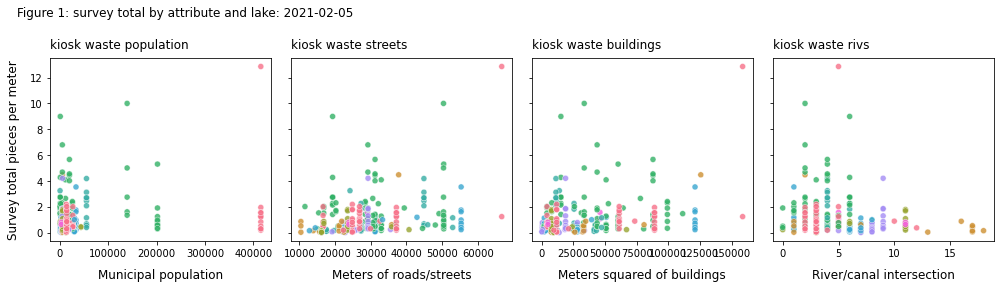

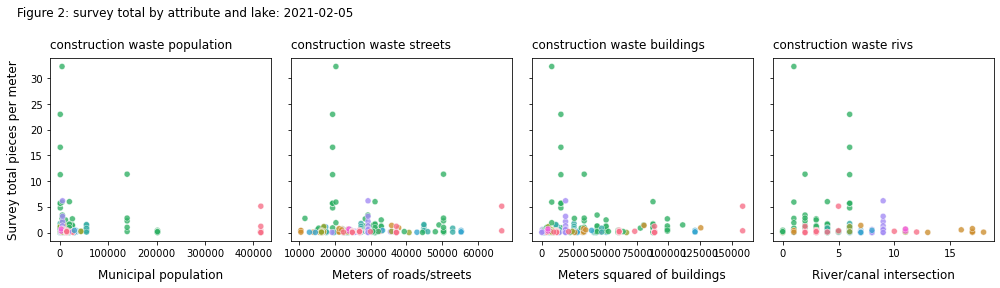

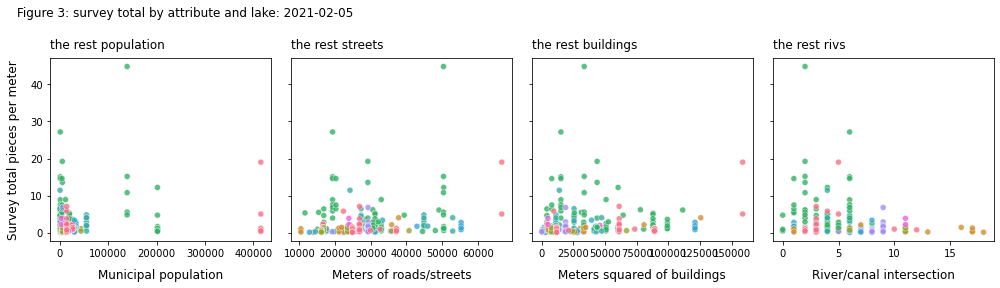

In [3]:
# figure one total survey pcs/m per attribute value:


# key the column names to appropriate chart titles:
titles_text = {
    'population':'Municipal population',
    'streets': 'Meters of roads/streets',
    'buildings':'Meters squared of buildings',
    'rivs':'River/canal intersection',
    
}

# produce a chart for each explanatory variable and each group
for i,name in enumerate(dt_names):
    fig, axs = plt.subplots(1,len(expv), figsize=(14,4), sharey=True)
    for j,att in enumerate(expv):
        data = groupdfs[name][['water_name','pcs_m', att]]
        ax = sns.scatterplot(data=data, x=att, y='pcs_m', hue='water_name', palette='husl', alpha=0.8, ax=axs[j])
        axs[j].set_title(F"{name[:-3]} {att}", **title_k)
        axs[j].set_xlabel(titles_text[att], **xlab_k)
        axs[j].set_ylabel('')
        axs[j].get_legend().remove()
    axs[0].set_ylabel('Survey total pieces per meter', **xlab_k)
#     handles, labels =  axs[i].get_legend_handles_labels()
#     plt.legend(handles, labels)
    plt.suptitle(F"Figure {figure_num}: survey total by attribute and lake: {end_date}", x=0.02, y=0.99, ha='left')
    figure_num += 1
    # save that
    figureonefile = F"{project_directory}/figure{figure_num}.jpg"
    files_generated.append(figureonefile)
    plt.savefig(figureonefile, dpi=300)


    plt.tight_layout()
    plt.show()
    plt.close()

In [4]:
# calculator: what ever other metric that needs to be calculated
# shoud be calculated here. Then they can be used in the narrative
# or applied to the regional results. Good place to look at
# correlation tables with geo data

# group by location and get the total found
# qGpi = dfCode.groupby(['location', 'water_name'], as_index=False).quantity.sum()

# seperate locations with or wothout the code
# noGpi = qGpi[qGpi.quantity == 0]
# hasGpi = qGpi[qGpi.quantity > 0]

# count the number of locations with the code value per lake
# lakes_with = hasGpi[['water_name', 'location']].groupby(['water_name']).nunique('location')

# total gpi found and percent of total
# numg112 = dfS[dfS.code.isin(group_one)].quantity.sum()
# numtotal = dfS.quantity.sum()
# g112_p_total = numg112/numtotal

# Frequency, surveys with code 
# qGpiD = dfCode.groupby(['location', 'water_name','loc_date', 'date'], as_index=False).pcs_m.sum()
# number_trys = len(qGpiD)
# number_fail = sum(qGpiD.pcs_m == 0)
# number_succ = len(qGpiD[qGpiD.pcs_m > 0])
# print("CODE total values")
# print(numg112)
# print(numtotal)
# print(g112_p_total)

# print("CODE trys and fails")
# print(number_trys)
# print(number_fail)
# print(number_succ)

# correlation with geo variables
# combining streets and buildings could be interesting:

# g112Df['combined'] = g112Df.streets + g112Df.buildings

# g112Df[['population', 'streets', 'buildings', 'rivs','combined', 'p_total', ]].corr('spearman')

#### <span style="color:#008891">Geographic scope of surveys</span>

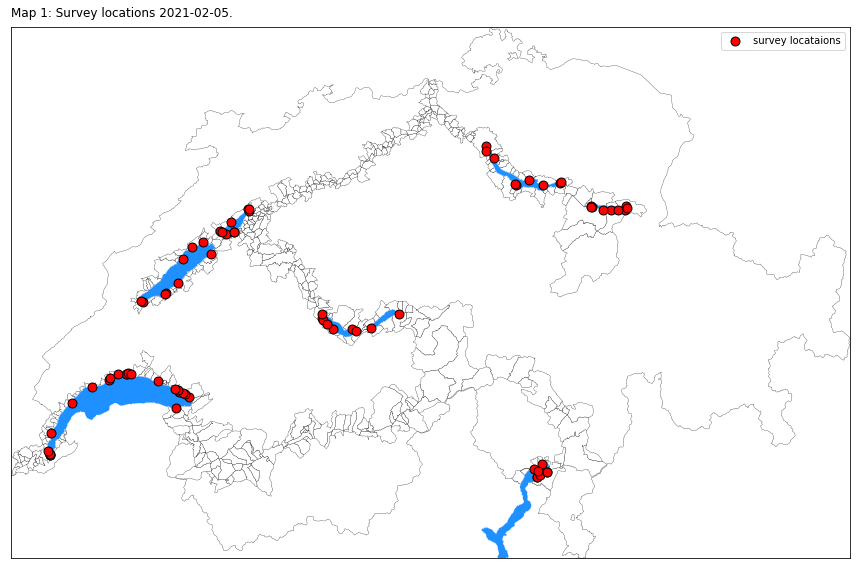

In [5]:
# import shapes
gdf = gpd.read_file('resources/shapes/riparian_communities.shp')
gdfch = gpd.read_file('resources/shapes/ch.shp')
gdflakes = gpd.read_file('resources/shapes/project_lakes.shp')

# make point layers, add survey results

# get the beaches from the location column of the data
beaches = dfBeaches.loc[dfBeaches.index.isin(groupdfs["dfDtAll"].location.unique())].copy()

# create map the median pcs/m to location
median_map = groupdfs["dfDtAll"].groupby('location').pcs_m.median().copy()

# apply the map to the beach data:
beaches['pcs_m'] = beaches.index.map(lambda x: median_map[x])

# port to gpd and reproject to the correct crs:
gbeaches = gpd.GeoDataFrame(beaches, crs='EPSG:4326', geometry=gpd.points_from_xy(beaches.longitude, beaches.latitude))
gdbeaches = gbeaches.to_crs(gdf.crs)

fig, axs = plt.subplots(figsize=(12,12))
axs.set_aspect('equal')

# plot the shapes and points:
gdfch.plot(ax=axs, zorder=0, color='white', edgecolor='black', linewidth=0.26)
gdf.plot(ax=axs, zorder=1, color='white', edgecolor='black', label='riparian coumminities', linewidth=0.26)
gdflakes.plot(ax=axs, zorder=2, color='dodgerblue', edgecolor='white', linewidth=0.26)
gdbeaches.plot(ax=axs, zorder=3, color='red', edgecolor='black',marker='o', label='survey locataions',  markersize=80)

# get and set the bounds
minx, miny, maxx, maxy = gdfch.total_bounds
axs.set_xticks([])
axs.set_yticks([])
axs.set_title(F"Map {map_num}: Survey locations {end_date}.", **title_k)
axs.set_xlim(minx, maxx)
axs.set_ylim(miny, maxy)
map_num + 1

handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, labels)
plt.tight_layout()

maponefile = F"{project_directory}/mapone.jpg"
files_generated.append(maponefile)
plt.savefig(maponefile, dpi=300)

plt.show()
plt.close()

### <span style="color:#1e90ff">Survey results</span>
(table 1)

In [6]:
# make summary of data and put to table:
# summarize the total pcs/m per survey
# use pd.describe and omit the first element (count)
sum_tables = []
for name in dt_names:
    a_row = list(groupdfs[name].pcs_m.describe().index[1:])
    a_data = [[np.round(groupdfs[name].pcs_m.describe()[i], 2)] for i in a_row]
    one_table = {'data':a_data, 'a_row':a_row, 'name':name}
    sum_tables.append(one_table)
sum_tables[2]['data']

[[2.5], [4.37], [0.05], [0.54], [1.21], [2.39], [44.84]]

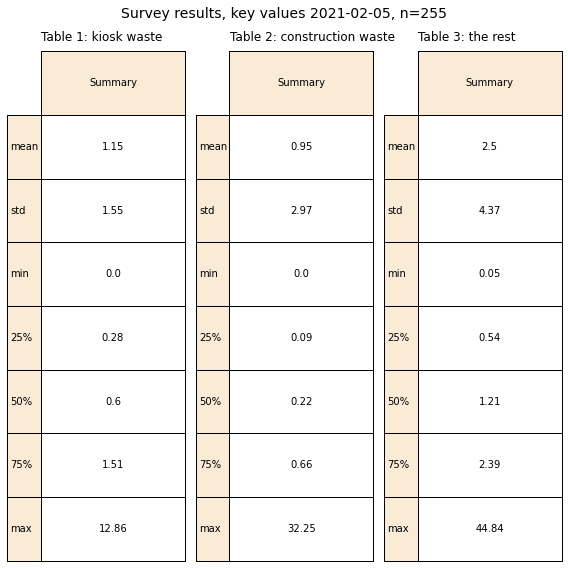

In [7]:
fig, axs = plt.subplots(1,len(sum_tables), figsize=(8,8))

for i, table in enumerate(sum_tables):
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["bottom"].set_visible(False)
    axs[i].spines["left"].set_visible(False)
    axs[i].grid(False)
    axs[i].add_table(
        mpl.table.table(
            cellText=table['data'],
            rowLabels=table['a_row'],
            colLabels=['Summary'],
            colColours=['antiquewhite' for i in np.arange(1)],
            rowColours=['antiquewhite' for i in np.arange(len(table['a_row']))],
            ax=axs[i],
            **tablecenter_k))
    axs[i].tick_params(**tabtickp_k)
    axs[i].set_title(F"Table {table_num}: {table['name'][:-3]}", **title_k)
    table_num += 1
    

plt.suptitle(F"Survey results, key values {end_date}, n={len(groupdfs['dfDtAll'])}", x=.5, y=0.98, ha='center', fontsize=(14))
tableonefile = F"{project_directory}/tableone.jpg"
files_generated.append(tableonefile)
plt.savefig(tableonefile, dpi=300)

plt.tight_layout()
plt.box(on=None)
plt.show()
plt.close()

#### <span style="color:#008891">Regional summary</span>

(table 2).

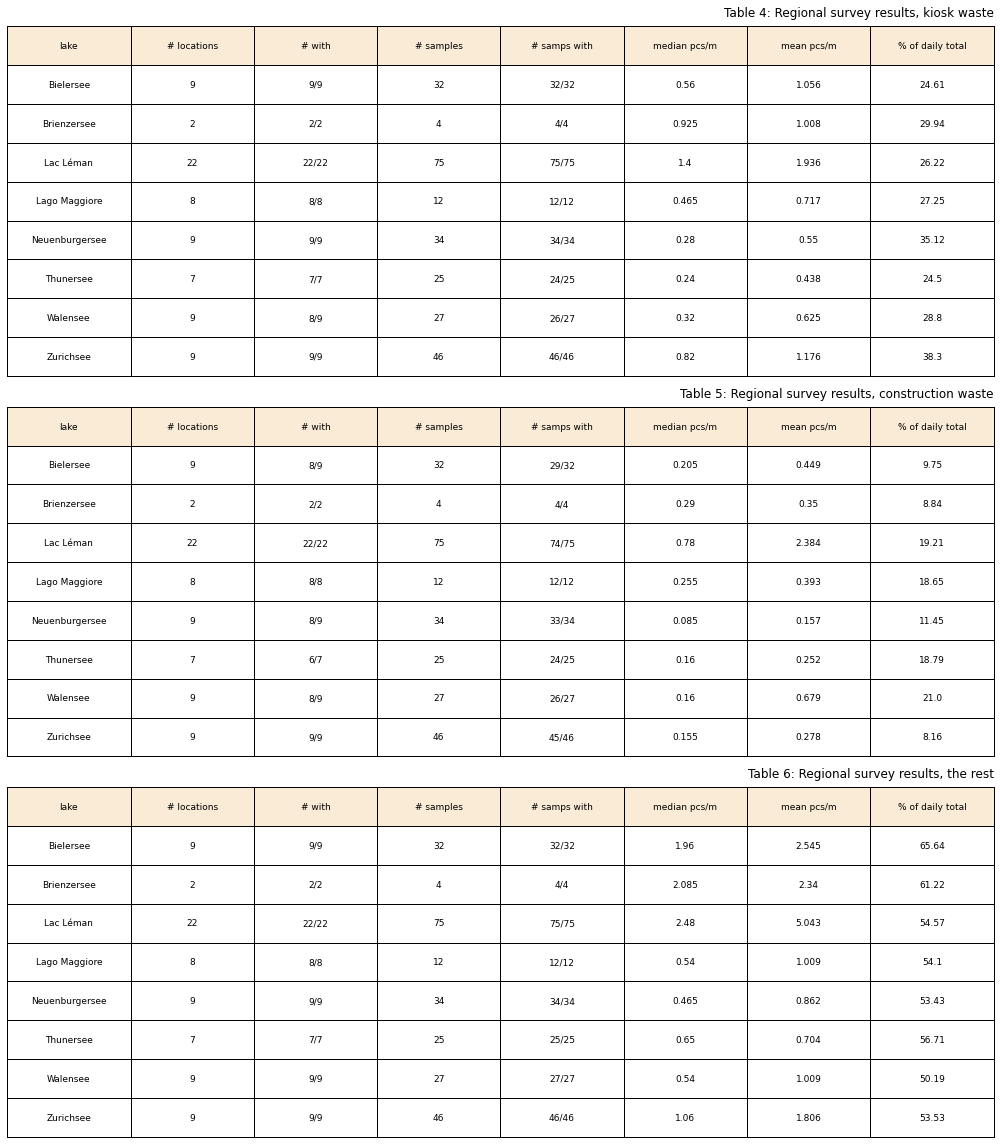

In [8]:
# adjust table args if need:
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center', fontsize=12)

fig, axs = plt.subplots(len(regional_summaries), 1, figsize=(14,16))

for i, name in enumerate(dt_names):
    axs[i].add_table(mpl.table.table(cellText=regional_summaries[i]['data'] , colLabels=regional_summaries[i]['cols'],colColours=['antiquewhite' for col in regional_summaries[i]['cols']], ax=axs[i], **tablecenter_k))
    axs[i].grid(False)
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["bottom"].set_visible(False)
    axs[i].spines["left"].set_visible(False)
    axs[i].tick_params(**tabtickp_k)
    axs[i].set_title(F"Table {table_num}: Regional survey results, {name[:-3]}", **titler_k)
    table_num += 1

# tabletwofile = F"{project_directory}/tabletwo.jpg"
# files_generated.append(tabletwofile)
# plt.savefig(tabletwofile, dpi=300)

plt.tight_layout()
plt.box(on=None)
plt.show()
plt.close()

### <span style="color:#008891">Distribution of survey results</span>
(fig 3).

In [9]:
monthly_median = {}
for name in dt_names:
    somdata = groupdfs[name].copy()
    somdata.set_index('date', inplace=True)
    monthly = somdata.resample('M').pcs_m.median()
    monthly_median.update({name:[monthly, somdata]})

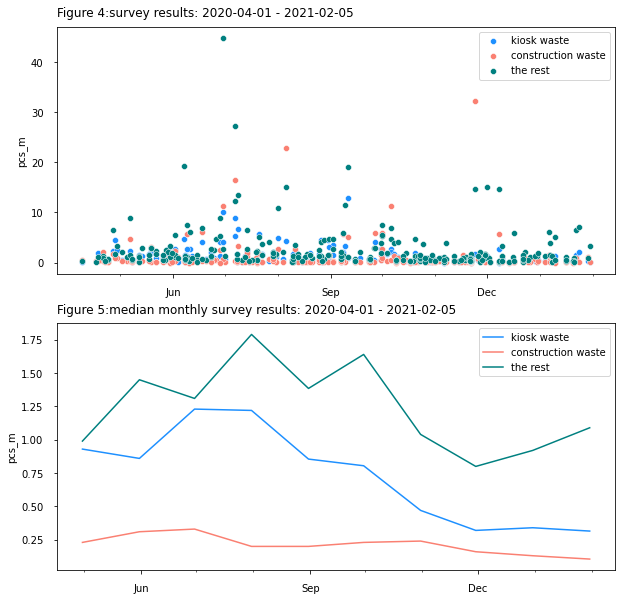

In [10]:
fig, axs = plt.subplots(2,1,figsize=(10,10))
colors = ['dodgerblue', 'salmon', 'teal']

# results by lake
for i,name in enumerate(dt_names):
    data = monthly_median[name][1]
    sns.scatterplot(data=data, x=data.index,  y='pcs_m', label=name[:-3], color=colors[i], ax=axs[0])
for i,name in enumerate(dt_names):
    data = monthly_median[name][0]
    sns.lineplot(data=data, x=data.index,  y=data, label=name[:-3], color=colors[i], ax=axs[1])
axs[0].xaxis.set_minor_locator(days)
axs[0].xaxis.set_major_formatter(mths_fmt)
axs[0].xaxis.set_major_locator(months)
axs[0].tick_params(which='major', pad=10)
axs[0].set_xlabel("")
labels, handles = axs[0].get_legend_handles_labels()
axs[0].legend(labels, handles)
axs[0].set_title(F"Figure {figure_num}:survey results: {start_date} - {end_date}", **title_k)
figure_num += 1
    
axs[1].set_title(F"Figure {figure_num}:median monthly survey results: {start_date} - {end_date}", **title_k)
figure_num +=1
axs[1].xaxis.set_minor_locator(days)
axs[1].xaxis.set_major_formatter(mths_fmt)
axs[1].xaxis.set_major_locator(months)
axs[1].tick_params(which='major', pad=10)
axs[1].set_xlabel("")
labels, handles = axs[1].get_legend_handles_labels()
axs[1].legend(labels, handles)

plt.show()
plt.close()

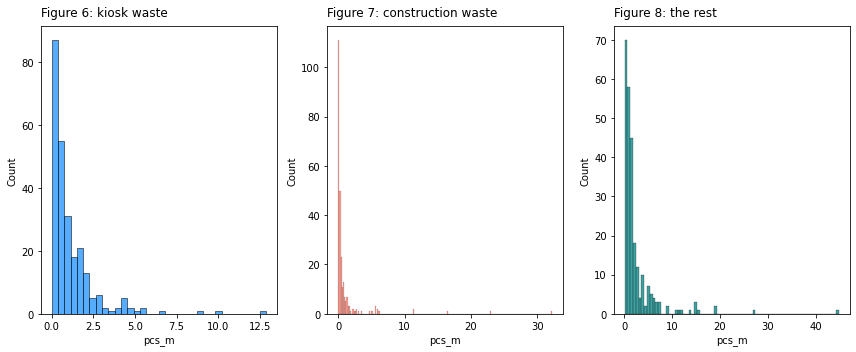

In [11]:
fig, axs = plt.subplots(1,len(dt_names), figsize=(12,5))


for i,name in enumerate(dt_names):
    data = groupdfs[name]
    sns.histplot(
        data=data,
        x=data.pcs_m,
        label=name[:-3],
        color=colors[i],
        stat='count',
        ax=axs[i])
    axs[i].set_title(F"Figure {figure_num}: {name[:-3]}", **title_k)
    figure_num += 1
    
plt.tight_layout()
plt.show()
plt.close()

### <span style="color:#008891">Definition of significant values</span>

Significant values are those survey values that are equal to or exceed the 90th percentile of all survey results for the defined code.

(table 3, fig 4).

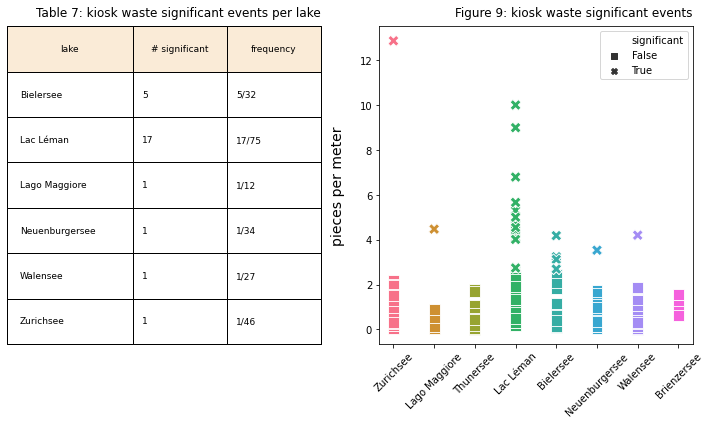

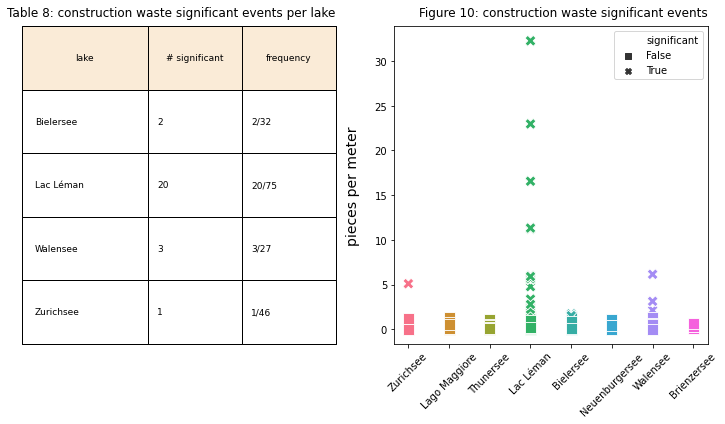

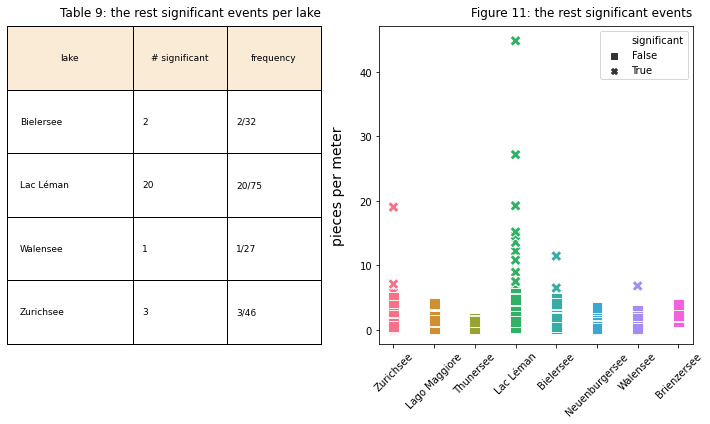

In [12]:
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='left', fontsize=10, colWidths = [0.4, 0.3, 0.3])

for i,name in enumerate(dt_names):
    fig, axs = plt.subplots(1,2, figsize=(10,6))
    
    # table of significant events
    axs[0].add_table(mpl.table.table(
        cellText=events_data[name].values,
        colLabels=events_data[name].columns,
        colColours=['antiquewhite' for col in events_data[name].columns],
        ax=axs[0],
        **tablecenter_k))
#     axs[0].set_fontsize(12)
    axs[0].grid(False)
    axs[0].spines["top"].set_visible(False)
    axs[0].spines["right"].set_visible(False)
    axs[0].spines["bottom"].set_visible(False)
    axs[0].spines["left"].set_visible(False)
    axs[0].tick_params(**tabtickp_k)
    axs[0].set_title(F"Table {table_num}: {name[:-3]} significant events per lake", **titler_k)
    table_num+=1
    
#     significant events by lake
    ax2 = sns.scatterplot(data=groupdfs[name],
                          x='water_name',
                          y='pcs_m',
                          hue='water_name',
                          style='significant',
                          s=120, ax=axs[1],
                          palette='husl',
                          markers={True:'X', False:'s'})
    ax2.xaxis.set_tick_params(rotation=45)
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_horizontalalignment("right")
    ax2.set_xlabel("")
    ax2.set_ylabel("pieces per meter", **ylab_k)
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles[9:], labels[9:])
    ax2.set_title(F"Figure {figure_num}: {name[:-3]} significant events", **titler_k)
    figure_num += 1
    
    plt.tight_layout()
#     figfourfile = F"{project_directory}/figurefourtablethree.jpg"
#     files_generated.append(figfourfile)
#     plt.savefig(figfourfile,dpi=300)
    plt.show()
    plt.close()

### <span style="color:#008891">Geographic scope</span>

In [13]:
# make the data for a map
# map median pcs_m to location
new_map_data = {}
for i,name in enumerate(dt_names):
    somdata = groupdfs[name]
    
    
    median_map = somdata.groupby('location').pcs_m.median().copy()

    # identify the beaches with no code:
    nogpi = somdata[somdata.pcs_m == 0]
    noGpibeaches = dfBeaches.loc[dfBeaches.index.isin(nogpi.location.unique())].copy()
    # apply the map
#     noGpibeaches['pcs_m'] = noGpibeaches.index.map(lambda x: median_map[x])

    # repeat for the places where code was found:
    hasGpi = somdata[somdata.pcs_m > 0]
    gpbeaches = dfBeaches.loc[dfBeaches.index.isin(hasGpi.location.unique())].copy()
    gpbeaches['pcs_m'] = gpbeaches.index.map(lambda x: median_map[x])

    # repeat one more time for significant events:
    sign = somdata[somdata.significant == True]
    gpsbeaches = dfBeaches.loc[dfBeaches.index.isin(sign.location.unique())].copy()
    gpsbeaches['pcs_m'] = gpsbeaches.index.map(lambda x: median_map[x])

    # call gpd on datafarames
    gbeaches = gpd.GeoDataFrame(noGpibeaches, crs='EPSG:4326', geometry=gpd.points_from_xy(noGpibeaches.longitude, noGpibeaches.latitude))
    gpibeaches = gpd.GeoDataFrame(gpbeaches, crs='EPSG:4326', geometry=gpd.points_from_xy(gpbeaches.longitude, gpbeaches.latitude))
    gpsigbeaches = gpd.GeoDataFrame(gpsbeaches, crs='EPSG:4326', geometry=gpd.points_from_xy(gpsbeaches.longitude, gpsbeaches.latitude))

    # reproject to correct crs
    gdbeaches = gbeaches.to_crs(gdf.crs)
    gpibeaches = gpibeaches.to_crs(gdf.crs)
    gpsigbeaches = gpsigbeaches.to_crs(gdf.crs)
    ma_p_data = {name:[gdbeaches, gpibeaches, gpsigbeaches]}
    
    new_map_data.update(ma_p_data)

In [14]:
new_map_data['kiosk waste_dt'][0].columns

Index(['location', 'latitude', 'longitude', 'post', 'country', 'water',
       'water_name', 'city_slug', 'water_na_1', 'is_2020', 'city', 'bfsnum',
       'population', 'intersects', 'buildings', 'streets', 'intersects',
       'pop_group_proj', 'pop_group_rip', 'streets_rank', 'buildings_rank',
       'geometry'],
      dtype='object')

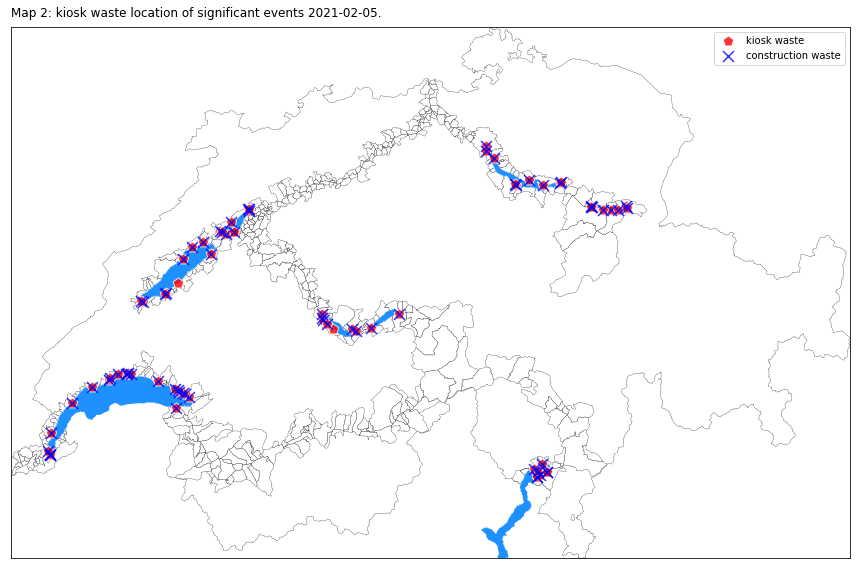

In [15]:
colors = ['red', 'blue', 'green']
markers = ['p', 'x', 'o']

fig, axs = plt.subplots(figsize=(12,12))
axs.set_aspect('equal')

# plot the geo data
gdfch.plot(ax=axs, zorder=0, color='white', edgecolor='black', linewidth=0.26)
gdf.plot(ax=axs, zorder=1, color='white', edgecolor='black', label='riparian coumminities', linewidth=0.26)
gdflakes.plot(ax=axs, zorder=2, color='dodgerblue', edgecolor='white', linewidth=0.26)
for j, name in enumerate(dt_names[:2]):
    somdata = new_map_data[name][1]
    somdata.plot(ax=axs, zorder=3, color=colors[j], edgecolor='white',marker=markers[j], alpha=0.8, label=F"{name[:-3]}", markersize=(140-(10*i)))
#         .plot(ax=axs, zorder=3, color='yellow', edgecolor='red',marker='o', label=F"{code} found", markersize=80)
# gpsigbeaches.plot(ax=axs, zorder=4, color='red', edgecolor='red',marker='o', label=F"{code} significant", markersize=80)

# get and set map bounds
minx, miny, maxx, maxy = gdfch.total_bounds
axs.set_xticks([])
axs.set_yticks([])
axs.set_title(F"Map 2: {group_one_name} location of significant events {end_date}.", **title_k)
axs.set_xlim(minx, maxx)
axs.set_ylim(miny, maxy)

handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, labels)

plt.tight_layout()
maptwofile = F"{project_directory}/maptwo.jpg"
files_generated.append(maptwofile)
plt.savefig(maptwofile, dpi=300)

plt.show()
plt.close()

### <span style="color:#1e90ff">Lac Léman results and conclusions</span>
table 4, figure 5, table 5

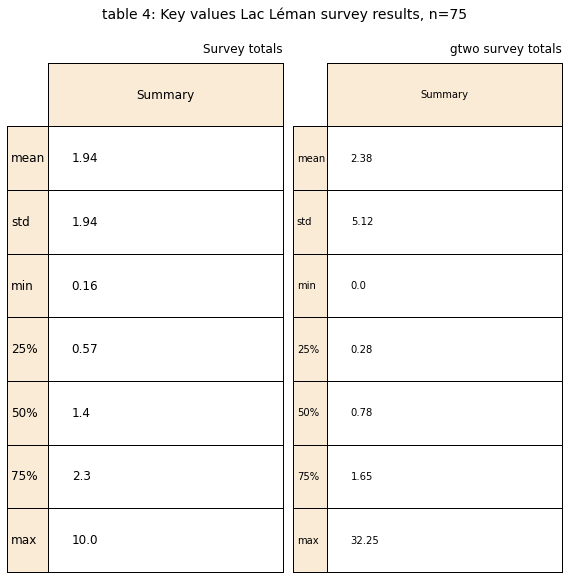

In [16]:
# make summary of data and put to table:
leman_data = {k:v.loc[v.water_name == lake] for k,v in groupdfs.items()}
# summarize the total pcs/m per survey:
# use pd.describe and omit the first element (count):
leman_summary = [[np.round(leman_data['kiosk waste_dt'].pcs_m.describe()[i], 2)] for i in leman_data['kiosk waste_dt'].pcs_m.describe().index[1:]]
# use the index for the row labels:
dtotal_rowlabels=leman_data['kiosk waste_dt'].pcs_m.describe().index[1:]

# repeat for the code o
g112Dt_summary = [[np.round(leman_data['construction waste_dt'].pcs_m.describe()[i], 2)] for i in leman_data['construction waste_dt'].pcs_m.describe().index[1:]]
g112Dt_rowlabels=leman_data['construction waste_dt'].pcs_m.describe().index[1:]

fig, axs = plt.subplots(1,2, figsize=(8,8))
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='left', fontsize=10, colWidths = [1])

anax = axs[0].add_table(mpl.table.table(cellText=leman_summary,rowLabels=dtotal_rowlabels, colLabels=['Summary'],colColours=['antiquewhite' for i in np.arange(1)], rowColours=['antiquewhite' for i in np.arange(len(dtotal_rowlabels))],  ax=axs[0], **tablecenter_k))
anax.set_fontsize(12)
axs[0].grid(False)
axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].spines["bottom"].set_visible(False)
axs[0].spines["left"].set_visible(False)
axs[0].tick_params(**tabtickp_k)
axs[0].set_title(F"Survey totals", **titler_k)


anax1 = axs[1].add_table(mpl.table.table(cellText=g112Dt_summary,rowLabels=g112Dt_rowlabels, colLabels=['Summary'],colColours=['antiquewhite' for i in np.arange(1)], rowColours=['antiquewhite' for i in np.arange(len(g112Dt_rowlabels))],  ax=axs[1], **tablecenter_k))
anax.set_fontsize(12)
axs[1].grid(False)
axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].spines["bottom"].set_visible(False)
axs[1].spines["left"].set_visible(False)
axs[1].tick_params(**tabtickp_k)
axs[1].set_title(F"{code} survey totals", **titler_k)


plt.suptitle(F"table 4: Key values {lake} survey results, n={len(leman_data['kiosk waste_dt'])}", x=.5, y=1, ha='center', fontsize=(14))
plt.tight_layout()
# tablefourfile = F"{project_directory}/tablefour.jpg"
# files_generated.append(tablefourfile)
# plt.savefig(tablefourfile, dpi=300)
plt.box(on=None)
plt.show()
plt.close()

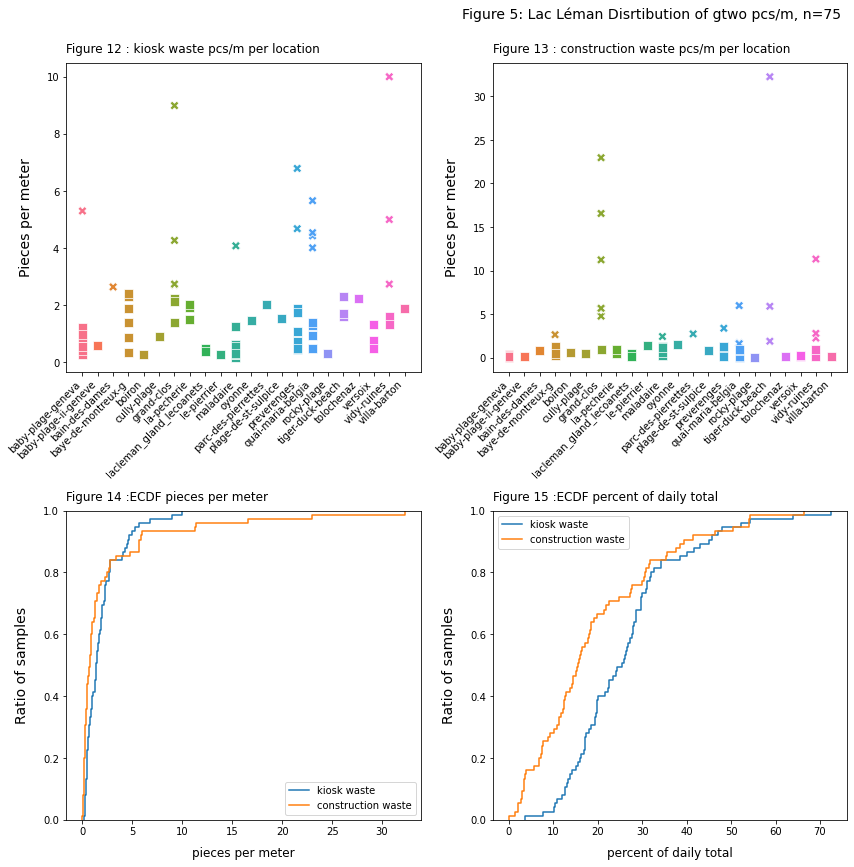

In [17]:
fig, axs = plt.subplots(2,2, figsize=(12,12))

# results grouped by beach
ax = sns.scatterplot(data=leman_data['kiosk waste_dt'], x='location',  y='pcs_m', style='significant', markers={True:'X', False:'s'}, hue='location', marker="s", s=80, palette='husl', ax=axs[0,0])
ax.xaxis.set_tick_params(rotation=45)
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")
ax.set_xlabel("")
ax.get_legend().remove()
ax.set_title(F"Figure {figure_num} : {dt_names[0][:-3]} pcs/m per location", **title_k)
ax.set_ylabel("Pieces per meter", **ylab_k)
figure_num += 1

# results by date
ax2 = sns.scatterplot(data=leman_data['construction waste_dt'], x='location',  y='pcs_m', style='significant', markers={True:'X', False:'s'}, hue='location', marker="s", s=80, palette='husl', ax=axs[0,1])
ax2.xaxis.set_tick_params(rotation=45)
for tick in ax2.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")
ax2.set_xlabel("")
ax2.get_legend().remove()
ax2.set_title(F"Figure {figure_num} : {dt_names[1][:-3]} pcs/m per location", **title_k)
ax2.set_ylabel("Pieces per meter", **ylab_k)
figure_num += 1
# ax2 = sns.scatterplot(data=leman_data['kiosk waste_dt'], x='date', y='pcs_m', hue='location', style='significant',s=80, palette='husl', markers={True:'X', False:'s'},ax=axs[0,1])
# ax2.set_title(F"{code} Lac Léman survey results", **title_k)
# ax2.xaxis.set_minor_locator(days)
# ax2.xaxis.set_major_formatter(mths_fmt)
# ax2.xaxis.set_major_locator(months)
# ax2.tick_params(which='major', pad=10)
# ax2.set_xlabel("")
# ax2.set_ylabel("Pieces per meter", **ylab_k)


# table of significant events
ax3 = sns.ecdfplot(data=leman_data['kiosk waste_dt'], x='pcs_m',label='kiosk waste', ax=axs[1,0])
ax3 = sns.ecdfplot(data=leman_data['construction waste_dt'], x='pcs_m', label='construction waste',  ax=axs[1,0])
ax3.set_title(F"Figure {figure_num} :ECDF pieces per meter", **title_k)
ax3.set_xlabel("pieces per meter", **xlab_k)
ax3.set_ylabel("Ratio of samples", **ylab_k)
labels, handles = ax3.get_legend_handles_labels()
ax3.legend(labels, handles)
figure_num += 1
# to be decided
ax4 = sns.ecdfplot(data=leman_data['kiosk waste_dt'], x='p_total',label='kiosk waste', ax=axs[1,1])
ax4 = sns.ecdfplot(data=leman_data['construction waste_dt'], x='p_total', label='construction waste',  ax=axs[1,1])
ax4.set_title(F"Figure {figure_num} :ECDF percent of daily total", **title_k)
ax4.set_xlabel("percent of daily total", **xlab_k)
ax4.set_ylabel("Ratio of samples", **ylab_k)
labels, handles = ax4.get_legend_handles_labels()
ax4.legend(labels, handles)
figure_num += 1

plt.suptitle(F"Figure 5: Lac Léman Disrtibution of {code} pcs/m, n={len(leman_data['kiosk waste_dt'])}", x=.98, y=1, ha='right', fontsize=(14))


plt.tight_layout()
# figfivefile = F"{project_directory}/figurefive.jpg"
# files_generated.append(figfivefile)
# plt.savefig(figfivefile, dpi=300)
plt.show()
plt.close()

### <span style="color:#1e90ff">Use and distribution</span>
(map 3).

['G27', 'G35', 'G30', 'G25', 'G31', 'G32', 'G33', 'G34', 'G21', 'G24']


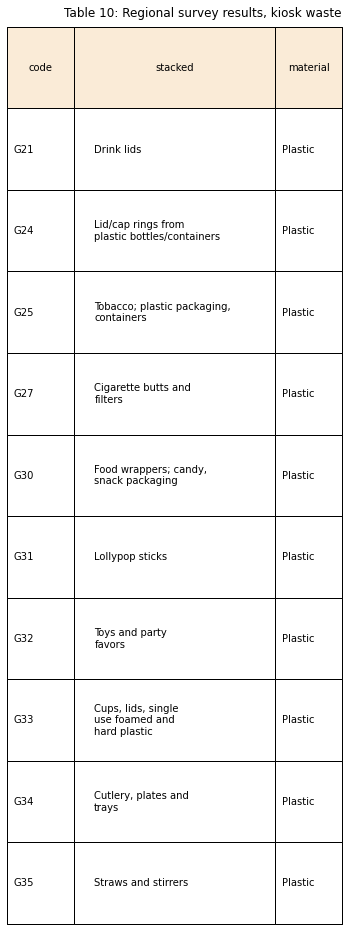

['G9', 'G17', 'G22', 'G66', 'G68', 'G69', 'G72', 'G73', 'G74', 'G81', 'G82', 'G83', 'G87', 'G89', 'G93', 'G160', 'G162', 'G169', 'G174', 'G186', 'G188', 'G189', 'G190', 'G194', 'G908', 'G921', 'G931']


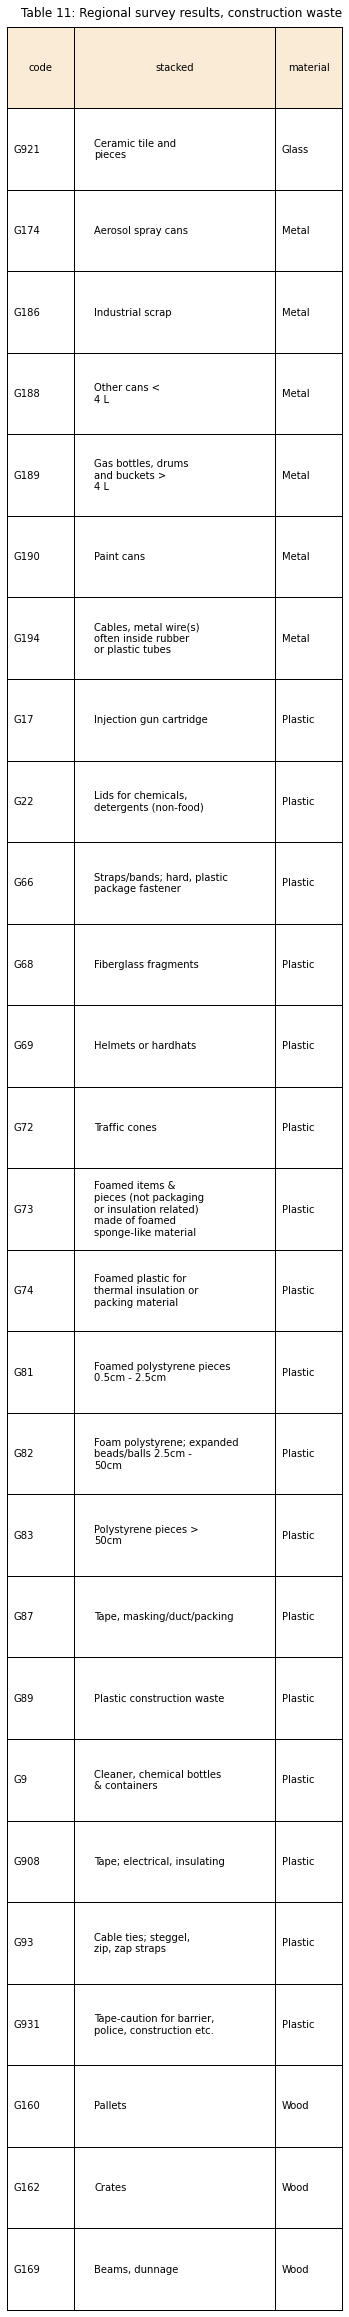

['G1', 'G10', 'G100', 'G101', 'G102', 'G103', 'G104', 'G105', 'G106', 'G107', 'G108', 'G109', 'G11', 'G111', 'G112', 'G113', 'G114', 'G115', 'G116', 'G117', 'G118', 'G119', 'G12', 'G122', 'G123', 'G124', 'G125', 'G126', 'G128', 'G129', 'G13', 'G131', 'G132', 'G133', 'G134', 'G135', 'G136', 'G137', 'G138', 'G139', 'G14', 'G140', 'G141', 'G142', 'G143', 'G144', 'G145', 'G146', 'G147', 'G148', 'G149', 'G150', 'G151', 'G152', 'G153', 'G154', 'G155', 'G156', 'G157', 'G158', 'G159', 'G161', 'G165', 'G166', 'G167', 'G170', 'G171', 'G172', 'G173', 'G175', 'G176', 'G177', 'G178', 'G179', 'G180', 'G181', 'G182', 'G185', 'G19', 'G191', 'G193', 'G195', 'G197', 'G198', 'G199', 'G2', 'G20', 'G200', 'G201', 'G202', 'G203', 'G204', 'G205', 'G208', 'G210', 'G211', 'G213', 'G214', 'G23', 'G26', 'G28', 'G29', 'G3', 'G36', 'G37', 'G38', 'G39', 'G4', 'G40', 'G41', 'G43', 'G48', 'G49', 'G5', 'G50', 'G52', 'G53', 'G55', 'G56', 'G59', 'G6', 'G60', 'G61', 'G62', 'G63', 'G64', 'G65', 'G67', 'G7', 'G70', 'G71', 

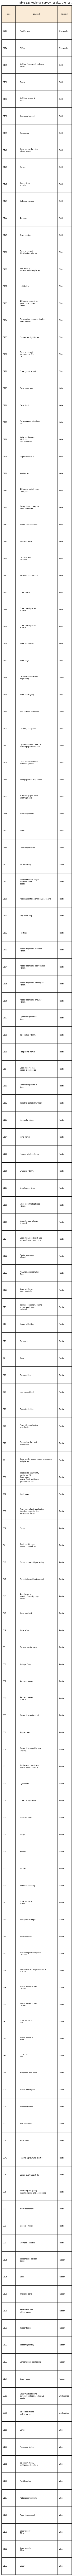

In [18]:
def splitText(string, w=3):
    words = string.split()
    g = [' '.join(words[i: i + w]) for i in range(0, len(words), w)]
    a_stack =  '\n'.join(g)
    return a_stack
dfCodes['stacked'] = dfCodes.description.map(lambda x:splitText(x, w=3))
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='left', fontsize=10, colWidths = [0.2, 0.6, 0.2])

for i, group in enumerate(project_groups):
    print(group)
    height=(len(group)+1)*1.5
    fig, axs = plt.subplots(figsize=(6, height))
    som_data = dfCodes[dfCodes.code.isin(group)][['code', 'stacked', 'material']]
    a = plt.table(cellText=som_data.values,
                  colLabels=som_data.columns,
                  colColours=['antiquewhite' for col in data.columns],
                  **tablecenter_k)
    axs.add_table(a)
    axs.grid(False)
    axs.spines["top"].set_visible(False)
    axs.spines["right"].set_visible(False)
    axs.spines["bottom"].set_visible(False)
    axs.spines["left"].set_visible(False)
    axs.tick_params(**tabtickp_k)
    axs.set_title(F"Table {table_num}: Regional survey results, {dt_names[i][:-3]}", **titler_k)
    table_num += 1
    plt.show()
    plt.close()

In [19]:
# get the beaches for the lake in question
lemanbeaches =  dfBeaches.loc[dfBeaches.water_name == lake].copy()

# find the ones that have zero for the code quantity or pcs_m:
noGpibeaches = lemanbeaches.loc[lemanbeaches.index.isin(noGpi.location.unique())].copy()

# make a map of the location and the median pcs_m for that location
median_map = g112Df.groupby('location').pcs_m.median().copy()

# map location of no gpi to the median value in g112Df:
noGpibeaches['pcs_m'] = noGpibeaches.index.map(lambda x: median_map[x])

# get the ones that have greater than zero for the code:
gpbeaches = lemanbeaches.loc[lemanbeaches.index.isin(hasGpi.location.unique())].copy()

# map location of gpbeaches to the median value in g112Df:
gpbeaches['pcs_m'] = gpbeaches.index.map(lambda x: median_map[x])

gpsbeaches = lemanbeaches.loc[lemanbeaches.index.isin(p_dt90_s.location.unique())].copy()
gpsbeaches['pcs_m'] = gpsbeaches.index.map(lambda x: median_map[x])

# make geodata frames
gbeaches = gpd.GeoDataFrame(noGpibeaches, crs='EPSG:4326', geometry=gpd.points_from_xy(noGpibeaches.longitude, noGpibeaches.latitude))
gpibeaches = gpd.GeoDataFrame(gpbeaches, crs='EPSG:4326', geometry=gpd.points_from_xy(gpbeaches.longitude, gpbeaches.latitude))
gpsigbeaches = gpd.GeoDataFrame(gpsbeaches, crs='EPSG:4326', geometry=gpd.points_from_xy(gpsbeaches.longitude, gpsbeaches.latitude))

# get shape files 
leman_com = gpd.read_file('resources/shapes/leman_communesx.shp')
leman_filled = gpd.read_file('resources/shapes/leman_filledx.shp')
leman_ints = gpd.read_file('resources/shapes/leman_intersectsx.shp')

# if you have distribution points or user points load them here:
# gpi_sp = gpd.read_file('resources/shapes/gpi_spointsx.shp')

gdbeaches = gbeaches.to_crs(leman_ints.crs)
gpibeaches = gpibeaches.to_crs(leman_ints.crs)
gpsigbeaches = gpsigbeaches.to_crs(leman_ints.crs)

NameError: name 'noGpi' is not defined

In [ ]:

fig, axs = plt.subplots(figsize=(12,12))
axs.set_aspect('equal')

# plot the data frames
leman_ints.plot(ax=axs, zorder=1, color='dodgerblue', linewidth=0.26)
leman_filled.plot(ax=axs, zorder=2, color='dodgerblue', edgecolor='dodgerblue', label='riparian coumminities', linewidth=0.26)
leman_com.plot(ax=axs, zorder=0,  color='white', edgecolor='black', linewidth=0.26)
gdbeaches.plot(ax=axs, zorder=3, color='slategray', edgecolor='black',marker='o', label=F"{code} not found", markersize=markerSize)
gpibeaches.plot(ax=axs, zorder=4, color='yellow', edgecolor='red',marker='o', label=F"{code} found", markersize=markerSize)
gpsigbeaches.plot(ax=axs, zorder=5, color='red', edgecolor='red',marker='o', label=F"{code} significant", markersize=markerSize)

# these are distribution or user points, they are on top:
# gpi_sp.plot(ax=axs, zorder=6, color='red', edgecolor='red',marker='x', label=F"{code} supplier/user", markersize=markerSize) 


# set min max
minx, miny, maxx, maxy = leman_ints.total_bounds
axs.set_xticks([])
axs.set_yticks([])
axs.set_title(F"map 3: {lake} survey locations and {code} suppliers/users {end_date}.", **title_k)
axs.set_xlim(minx, maxx)
axs.set_ylim(miny, maxy)

# do work on legend if need
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, labels)

plt.tight_layout()

mapthreefile = F"{project_directory}/mapthree.jpg"
files_generated.append(mapthreefile)
plt.savefig(mapthreefile, dpi=300)

plt.show()
plt.close()

In [ ]:
# display the beach, the lake and the name of each municipality
# considered in this report

data = beaches[['water_name', 'location', 'city']].sort_values(by='water_name')
data.rename(columns={'water_name':'Lake', 'location':'Location','city':'Municipality'}, inplace=True)
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center', fontsize=14)


fig, ax = plt.subplots(figsize=(12,32))
ax1= ax.add_table(mpl.table.table(cellText=data.values, colLabels=data.columns,colColours=['antiquewhite' for col in data.columns], ax=ax, **tablecenter_k))
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(**tabtickp_k)
ax.set_title(F"annex a: Municipalities considered in this report", **titler_k)
plt.tight_layout()
plt.show()

#### Hopefully that just worked for you

if not contact analyst@hammerdirt.ch

In [ ]:
def css_styling():
    styles = open(F"{project_directory}/custom.css").read()
    return HTML(styles)
css_styling()